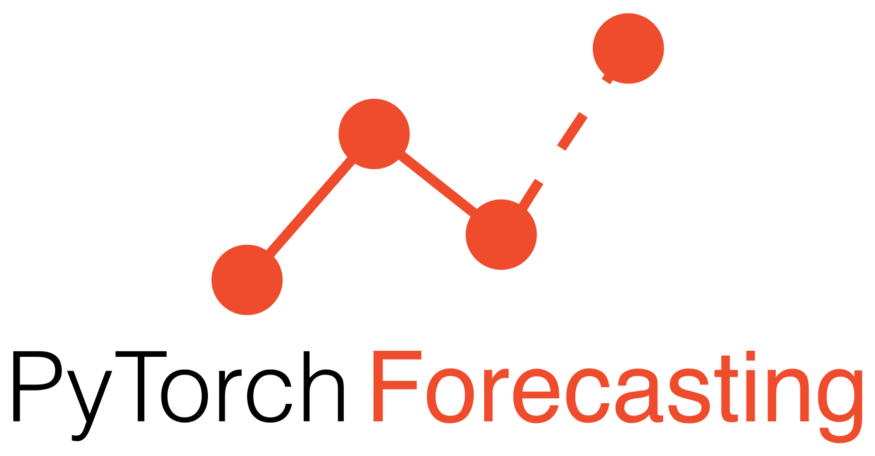

Deep Learning may have taken the front seat in computer vision and language processing tasks but ,even though having outperformed the traditional methods in time series forecasting tasks,deep learning architectures have not become mainstream yet for time series forecasting tasks.Other than the hardware requirements,the lack of a high-level API that would work with popular frameworks like PyTorch or Tensorflow has been a crucial impediment making it relatively difficult to use neural networks over the traditional methods(easy to use in the scikit learn ecosystem)

PyTorch Forecasting solves the problem by providing a high level API for PyTorch that can readily make use of the pandas dataframe.The package is built on PyTorch Lightning and PyTorch APIs,making it easier to learn.

Pytorch Forecasting aims to ease state-of-the-art timeseries forecasting with neural networks for both real-world cases and research alike.Some interesting provisions of the package include:

* A timeseries dataset class which abstracts handling variable transformations, missing values, randomized subsampling, multiple history lengths, etc.So,in short no specific knowledge on how to create a dataset for training your model in PyTorch is required.

* A base model class which provides basic training of timeseries models along with logging in tensorboard and generic visualizations such actual vs predictions and dependency plots

* Multiple neural network architectures for timeseries forecasting that have been enhanced for real-world deployment and come with in-built interpretation capabilities

* Multi-horizon timeseries metrics

* For scalability, the networks are designed to work with PyTorch Lightning which allows training on CPUs and single and multiple (distributed) GPUs out-of-the-box. 

* Hyperparameter tuning with optuna

# Let's Start

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">IMPORT THE LIBRARIES</h1></center>

In [1]:
!pip install pytorch_forecasting

     |████████████████████████████████| 112 kB 2.9 MB/s 


In [2]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">SEE THE DATA</h1></center>

In [3]:
df_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv' ,parse_dates=['date'])
df_shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
df_items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
df_item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')


In [4]:
df_train['date'] = pd.to_datetime(df_train['date'], errors='coerce')

In [5]:
df_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">ITEM COUNT/DAY--->ITEM COUNT/MONTH</h1></center>

In [6]:
# change the item count per day to item count per month by using group
df_train = df_train.groupby(["item_id","shop_id","date_block_num"]).sum().reset_index()
df_train = df_train.rename(index=str, columns = {"item_cnt_day":"item_cnt_month"})
df_train = df_train[["item_id","shop_id","date_block_num","item_cnt_month"]]
df_train

,item_id,shop_id,date_block_num,item_cnt_month
0,0,54,20,1.0
1,1,55,15,2.0
2,1,55,18,1.0
3,1,55,19,1.0
4,1,55,20,1.0
...,...,...,...,...
1609119,22168,12,8,1.0
1609120,22168,16,1,1.0
1609121,22168,42,1,1.0
1609122,22168,43,2,1.0


<center><h1 style = "font-size:20px;font-family: Comic Sans MS">DATE BLOCK NUM COLUMN</h1></center>

In [7]:
df_train['date_block_num'].describe()

count    1.609124e+06
mean     1.466479e+01
std      9.542322e+00
min      0.000000e+00
25%      6.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      3.300000e+01
Name: date_block_num, dtype: float64

<center><h1 style = "font-size:20px;font-family: Comic Sans MS"> Create The Time Series Dataset</h1></center>

This is a very important step and some prerequisites for defining a TimeSeriesDaataSet object is that our pandas dataframe must have each row such that they can be identified with a time step and a time series. Fortunately, most datasets are already in this format.In our Datafarme, the time step is defined by the date_block_num column,i.e. for every shop-item combination we have item count values for the months,and our test data wants us to predict the values for one month for all such shop-item combinations.

Some of the important parameters while defining the training object are:
* **min/max encoder length**:the mininmum and maximum lengths for encoding or the history length,for example if there are 20 time steps in total and we want a min encoder length=3 and max encoder length=8,then several sequences will be generated which are at least of length min_encoder_length and at most of length max_encoder_length and generally as large history as possible will be used.The advantage of this flexibility in the length is :If your dataset has also very short time series to predict, this flexibility ensures you can make predictions for these as well while using more history for longer time series.
* **min/max prediction length**:minimum/maximum prediction/decoder length 
* **group ids**:list of column names identifying a time series. This means that the group_ids identify a sample together with the time_idx. If you have only one timeseries, set this to the name of column that is constant.

For better understanding,refer to the [documentation](https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.data.timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries.TimeSeriesDataSet)

In [8]:
max_prediction_length = 1
max_encoder_length = 27
training_cutoff = df_train['date_block_num'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_train[lambda x: x['date_block_num'] <= training_cutoff],
    time_idx='date_block_num',
    target="item_cnt_month",
    group_ids=["shop_id", "item_id"],
    min_encoder_length=0,  
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=["shop_id", "item_id"],
    time_varying_known_categoricals=[],  
    time_varying_known_reals=['date_block_num'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['date_block_num'],
    categorical_encoders={'shop_id': pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),'item_id':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True)},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
    
)



<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Train and Validation Dataloaders</h1></center>

In [9]:
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Define the model :Temporal transfusion transformer</h1></center>
Model: Temporal Fusion Transformer
This is an architecture developed by Oxford University and Google that has beaten Amazon’s DeepAR by 36–69% in benchmarks,

In [10]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss=pytorch_forecasting.metrics.RMSE(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 19.4k


<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Use Lightning for suggesting a suitable learning rate </h1></center>

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

suggested learning rate: 4.5708818961487505e-07


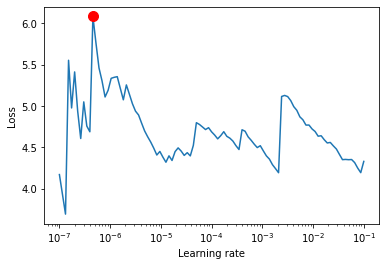

In [11]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-7,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Callbacks ,Trainer and final Model</h1></center>

In [12]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-7, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs") 

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=5e-7,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1, 
    loss=pytorch_forecasting.metrics.RMSE(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 19.4k


<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Fit the model</h1></center>

In [13]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Load the best model from Lightning checkpoint</h1></center>

In [14]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Get the validation RMSE</h1></center>

In [15]:
# calcualte root mean squared error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)

In [16]:
criterion = nn.MSELoss()
torch.sqrt(criterion(actuals,val_predictions))

tensor(6.6877)

You can always tune the model hyperparameters using OPTUNA along with pytorch forecasting,that will give a better score,feel free to fork the notebook and play around with the hyperparameters.

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Predict on the test data</h1></center>

In [17]:
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
df_test=df_test.drop(['ID'],axis=1)
df_test['date_block_num']=34
df_test['item_cnt_month']=0
# decoder_data=df_test
# encoder_data = df_train[lambda x: x.date_block_num > x.date_block_num.max() - max_encoder_length]
# new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
pred,x=best_tft.predict(df_test,return_x=True)